In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as pil
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from random import shuffle
import random

In [2]:
random.seed(42)

In [3]:
def conv(img, kernel):
    'Applies a 3x3 kernel to a given image'
    
    # kernel shape
    m, n = kernel.shape[0:2]
    
    # Pad image so the output remains the same dimensions as the input
    img = np.pad(img, pad_width = (m // 2, n // 2), mode = 'constant', constant_values=0.0)
    
    # Valid convolution coords
    valid_y = img.shape[0] - m + 1
    valid_x = img.shape[1] - n + 1
    
    # Create empty image matrix
    new_image = np.empty((valid_y, valid_x))
    
    # Convolve kernel over image
    for i in range(valid_y):
        for j in range(valid_x):
            
            # Compute dot product of of 3x3 area in image against kernel and add the 9 values to get convolution output
            new_image[i, j] = np.sum(img[i:i+m, j:j+n] * kernel)
    
    return new_image 

In [4]:
def harris_corners(filename, window_size, k):
    '''Applies the harris corner detector to an image and returns the eigenvalues of each point of interest
        as well as a 20x1 vector of the 10 most positive and 10 most negative R values '''
    
    # Load image as grayscale
    img = plt.imread(filename)
    
    height, width = img.shape[0:2]
    
    # Create sobel kernels
    kx = np.array([1, 0, -1, 2, 0, -2, 1, 0, -1]).reshape((3,3))
    ky = kx.transpose()
    
    # Apply sobel kernels in x and y direction
    Ix = conv(img, kx)
    Iy = conv(img, ky)
    
    # Computer pixel wise products of image gradients
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    # Calculate sum of squares using window function
    w = np.ones(shape=(window_size, window_size))
    Sxx = conv(Ixx, w)
    Syy = conv(Iyy, w)
    Sxy = conv(Ixy, w)
    
    # Arrays to hold harris responses and eigenvalues
    responses = np.zeros(shape=(height,width))
    eigs = []
    
    # Ensures calculated corner points are centered in window
    offset = window_size // 2
    
    # Compute the M matrix and response value for each pixel
    for i in range(offset, height - offset):
        for j in range(offset, width - offset):
            
            # Create M matrix
            M = np.array([Sxx[i, j], Sxy[i, j], Sxy[i,j], Syy[i, j]]).reshape((2,2))
            
            # Get eigenvalues
            eig1, eig2 = np.linalg.eigvals(M)
            
            # Document eigenvalues
            eig_vec = np.array([eig1, eig2]).reshape(2,1)
            eigs.append(eig_vec)
            
            # Calculate corner response values
            r = eig1 * eig2 - k * (eig1 + eig2) ** 2
            
            # Document harris response
            responses[i, j] = r
            
    eigs = np.array(eigs).squeeze().T
    
    # Get 10 largest and 10 smallest R values
    responses = responses.reshape(-1,1)
    responses.sort(axis = 0)
    smallest = responses[:10]
    largest = responses[-10:]
    
    # Create 20x1 feature vector
    feature_vector = np.concatenate((smallest, largest))
    
    return eigs, feature_vector

In [5]:
def covariance_matrix(features, means):
    'Calculates covariance matrix for a given set of features'

    X = np.array(features, dtype=np.float64)

    X -= means
    
    N = X.shape[1]
    
    cov = (X @ X.T) / N
    
    return cov

## Problem 1

In [6]:
image_file = os.path.join(os.getcwd(), 'assignment3_data/input_hcd1.jpg')

(466, 700)


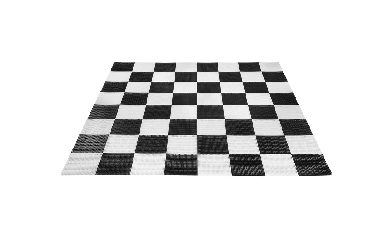

In [7]:
image = plt.imread(image_file)
print(image.shape)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
# Calculate eigenvalues of the hessian matrix at each point of interest

eigs, _ = harris_corners(image_file, 3, 0.05)

In [9]:
# Finding distribution of eigenvalues with respect to region types

# Calculate some statistics 
eig_mean = np.mean(eigs)
eig_std = np.std(eigs)

flats = []
edges = []
corners = []

for point in eigs.T:
    eig1 = point[0]
    eig2 = point[1]
    
    # 2 large eigenvalues signifies a corner
    if eig1 > (eig_mean + eig_std * 1.5) and eig2 > (eig_mean + eig_std * 1.5):
        corners.append(point)
    # Only one large eigenvalue signifies an edge
    if np.abs(eig1 - eig2) > eig_mean + eig_std * 1.5:
        edges.append(point)
    # 2 small eigenvalues signifies a corner
    else:
        flats.append(point)
        
flats = np.array(flats).T
edges = np.array(edges).T
corners = np.array(corners).T

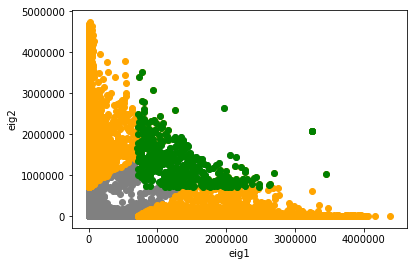

In [10]:
# Plotting eigenvalues for different region types

plt.scatter(flats[0], flats[1], c='gray')
plt.scatter(edges[0], edges[1], c='orange')
plt.scatter(corners[0], corners[1], c='green')
plt.xlabel('eig1')
plt.ylabel('eig2')
plt.show()

In [11]:
# Finding the parameters of the normal distribution for each type of region

labeled_points = {'flats' : flats, 'edges': edges, 'corners': corners}

means = {i: np.mean(labeled_points[i], axis=1).reshape(-1,1) for i in labeled_points.keys()}
covs = {i: covariance_matrix(labeled_points[i], means[i]) for i in labeled_points.keys()}

In [12]:
# Calculate Mahalanobis distance from each point of interest to each regions distribution
# Predict the class for which this calculation is the greatest

actuals = []
preds = []
labels = ['flats', 'edges', 'corners']

# Loop through each point of interest
for key, item in labeled_points.items():
    for point in item.T:
        # Add its label to actuals array
        actuals.append(key)
        x = point.reshape(-1, 1)
        
        dists = []
        # Calculate 3 mahalanobis distances, one for each of the 3 different region types
        for i in labels:
            dist = -0.5 * np.log(np.linalg.det(covs[i])) - 0.5 * ((x - means[i]).T @ np.linalg.inv(covs[i]) @ (x - means[i]))
            dists.append(dist)
        
        dists = np.array(dists)
        
        # Choose the region type which yields the largest distance
        pred = labels[dists.argmax()]
        
        # Add the point's prediction to the predictions array
        preds.append(pred)

actuals = np.array(actuals)
preds = np.array(preds)

In [13]:
# Creating a confusion matrix

cm = confusion_matrix(actuals, preds, labels)

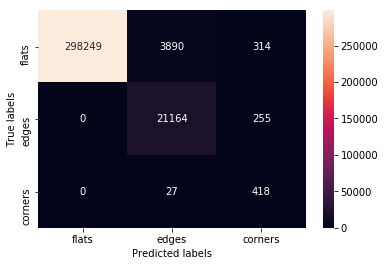

In [14]:
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='d', ax = ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');  
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [15]:
np.unique(actuals, return_counts=True)

(array(['corners', 'edges', 'flats'], dtype='<U7'),
 array([   445,  21419, 302453]))

In [16]:
np.unique(preds, return_counts=True)

(array(['corners', 'edges', 'flats'], dtype='<U7'),
 array([   987,  25081, 298249]))

In [19]:
np.mean(preds == actuals) * 100

98.61678542907094

In [20]:
np.mean(preds != actuals) * 100

1.38321457092906

## Problem 2

In [21]:
def calculate_features(digit, dataset):
    'Calculates a 20x1 feature vector for each image in a given class and returns the final feature matrix'
    
    # Empty feature matrix
    class_features = np.empty(shape = (20,0))
    
    # Loop through each file in a digit's folder
    for file in dataset[digit]:
        
        # Calculate features with harris corner detector
        eigs, features = harris_corners(os.path.join(digit_dataset, str(digit), file), 3, 0.05)
        
        # Add features to feature matrix
        class_features = np.append(class_features, features, axis = 1)

    return class_features

In [22]:
data_root = 'assignment3_data'

In [23]:
digit_dataset = os.path.join(os.getcwd(), data_root, 'DigitDataset')

In [24]:
# Getting the name of all the files in each of the digit folders

digit_files = {i: (os.listdir(os.path.join(digit_dataset, str(i)))) for i in range(10)}

In [25]:
# Shuffle the files names

for i in digit_files:
    shuffle(digit_files[i])

In [26]:
# Creating test and train sets, 50 files each

train_dataset = {i: digit_files[i][:50] for i in range(10)}
test_dataset = {i: digit_files[i][50:100] for i in range(10)}

In [27]:
# Uses harris corner detection to calculate a 20x50 feature matrix for each digit

train_features = {i: calculate_features(i, train_dataset) for i in range(10)}

In [28]:
# Average each feature across all images for each digit, creating a 20x1 mean vector for each digit

mean_dict = {i:  np.mean(train_features[i], axis = 1).reshape((-1,1)) for i in range(10)}

In [29]:
# Calculating the 20x20 covariance matrix for each of the 20x50 feature matrices

covariances = {i: covariance_matrix(train_features[i], mean_dict[i]) for i in range(10)}

In [30]:
# Average the covariance matrix for each of the digits, into a single 20x20 covariance matrix for the dataset

dataset_cov = []
for i in range(10):
    dataset_cov.append(covariances[i])
    
dataset_cov = np.array(dataset_cov)
dataset_cov = np.mean(dataset_cov, axis = 0)

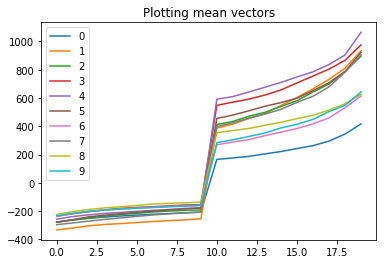

In [34]:
# Plotting means of digit features

for i in range(10):
    plt.plot(mean_dict[i])

plt.legend(range(10))
plt.title('Plotting mean vectors')
plt.show()

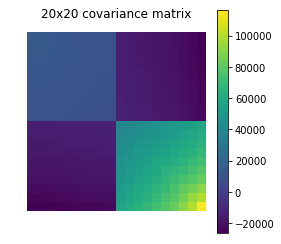

In [38]:
# Plotting the dataset's covariance matrix

plt.matshow(dataset_cov)
plt.colorbar()
plt.axis('off')
plt.title('20x20 covariance matrix')
plt.show()

## Testing on Training Set 

In [40]:
# create actuals array, this is always just simply 1 -10, 50 of each

actuals = np.array([i for i in range(10) for _ in range(50)])
labels = [i for i in range(10)]

In [41]:
def test_ldf(features, means, cov):
    'Uses a precalculated LDF to generate predictions given a set of features'
    preds = []

    # Loop through each class of digit
    for digit in range(10):

        # Loop through the precalculated feature vectors of each image in a class
        for x in range(features[digit].shape[1]):

            x_transpose = features[digit][:,x].transpose()
            gs = [] 

            # Loop and test on each LDA
            for i in range(10):

                h = np.linalg.inv(cov) @ means[i]
                b = 0.5 * (mean_dict[i].transpose() @ np.linalg.inv(cov) @ means[i])

                g = x_transpose @ h - b

                gs.append(g)

            gs = np.array(gs)
            pred = gs.argmax()

            preds.append(pred)

    preds = np.array(preds)
    
    return preds

In [42]:
# Using our linear discriminant functions to predict the class of digit for each image

train_preds = test_ldf(train_features, mean_dict, dataset_cov)

In [43]:
cm_train = confusion_matrix(actuals, train_preds, labels)

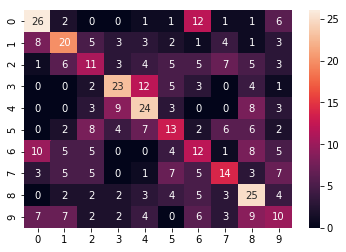

In [44]:
sn.heatmap(cm_train, annot=True)

In [45]:
# Probability of correct recognition on train set
np.mean(actuals == train_preds) 

0.356

In [46]:
# Probability of error on train set
np.mean(actuals != train_preds)

0.644

## Testing on Test Set 

In [47]:
# Calculating the 20x50 feature matrix of our test set

test_features = {i: calculate_features(i, test_dataset) for i in range(10)}

In [48]:
# Using our LDF's to predict on the test set

test_preds = test_ldf(test_features, mean_dict, dataset_cov)

In [49]:
test_cm = confusion_matrix(actuals, test_preds, labels)

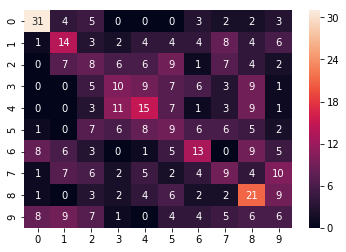

In [50]:
sn.heatmap(test_cm, annot=True)

In [51]:
# Probability of correct recognition on test set
np.mean(actuals == test_preds) 

0.272

In [52]:
# Probability of error on test set
np.mean(actuals != test_preds)

0.728